## Imports

In [1]:
import torch
import pandas as pd
import os

In [8]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [2]:
%run ../cxr14.py

## Split dataframe

### Check splits are correct

In [25]:
master_df_fpath = os.path.join(DATASET_DIR, 'label_index.csv')
train_df_fpath = os.path.join(DATASET_DIR, 'train_label.csv')
val_df_fpath = os.path.join(DATASET_DIR, 'val_label.csv')
test_df_fpath = os.path.join(DATASET_DIR, 'test_label.csv')

In [26]:
df = pd.read_csv(master_df_fpath)
master_images = set(df['FileName'])
print(len(master_images))
df.head()

112120


,FileName,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
def load_images_from_csv(fpath):
    df = pd.read_csv(fpath)
    return set(df['FileName'])

def load_images_from_txt(fpath):
    with open(fpath, 'r') as f:
        return set(l.strip() for l in f.readlines())

In [22]:
def check_same_images(split):
    df_path = os.path.join(DATASET_DIR, f'{split}_label.csv')
    txt_path = os.path.join(DATASET_DIR, 'splits', f'{split}.txt')
    
    txt_images = load_images_from_txt(txt_path)
    csv_images = load_images_from_csv(df_path)
    
    return txt_images == csv_images

In [24]:
check_same_images('train'), check_same_images('val'), check_same_images('test')

(True, True, True)

### Create test-bbox splits

In [28]:
bbox_df = pd.read_csv(os.path.join(DATASET_DIR, 'BBox_List_2017.csv'))
bbox_df.drop(columns=[c for c in bbox_df.columns if 'Unnamed' in c], inplace=True)
bbox_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [29]:
images_with_bbox = list(set(bbox_df['Image Index']))
len(images_with_bbox)

880

In [30]:
fpath = os.path.join(DATASET_DIR, 'splits', 'test-bbox.txt')
with open(fpath, 'w') as f:
    for image in images_with_bbox:
        f.write(f'{image}\n')

## Calculate mean and std

In [5]:
%run ../cxr14.py
%run ../../utils/images.py

In [6]:
dataset = CXR14Dataset('train')
len(dataset)

75714

In [7]:
train_images = list(dataset.label_index['FileName'])
len(train_images)

75714

In [11]:
mean, std = compute_mean_std(ImageFolderIterator(images_dir, train_images), show=True)
mean, std

(tensor([0.5058, 0.5058, 0.5058]), tensor([0.2320, 0.2320, 0.2320]))

In [12]:
print(mean)
print(std)

tensor([0.5058, 0.5058, 0.5058])
tensor([0.2320, 0.2320, 0.2320])


## Load class `CXR14Dataset`

In [1]:
from tqdm.notebook import tqdm

In [2]:
# %run ../cxr14.py
%run ../__init__.py

In [3]:
kwargs = {
    'dataset_name': 'cxr14',
    'dataset_type': 'test',
    'batch_size': 40,
}

dataloader = prepare_data_classification(**kwargs)
len(dataloader.dataset)

Loading cxr14/test dataset...


25596

In [12]:
dataset = CXR14Dataset('test', norm_by_sample=True)
len(dataset)

25596

In [4]:
for index, batch in enumerate(tqdm(dataloader)):
    pass

In [6]:
index

1

In [58]:
item = dataset[3]

In [60]:
sample = item.image.view(3, -1)
sample.mean(-1), sample.std(-1)

(tensor([4.4136e-05, 4.4136e-05, 4.4136e-05]),
 tensor([1.0000, 1.0000, 1.0000]))

## Debug transforms

In [8]:
import matplotlib.pyplot as plt

In [4]:
image_name = image_names[0]

In [5]:
fpath = os.path.join(images_dir, image_name)
image = Image.open(fpath).convert('RGB')

In [108]:
tensor_image = torch.rand(3, 1024, 1024)

In [107]:
tf = transforms.ColorJitter(contrast=0.5)

In [109]:
tf(tensor_image)

TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

In [110]:
tf = transforms.RandomRotation(15)

In [111]:
tf(tensor_image)

TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

In [112]:
tf = transforms.RandomAffine(0, translate=(0.1, 0.1))

In [113]:
tf(tensor_image)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [116]:
tf = transforms.RandomResizedCrop((1024, 1024), scale=(0.8, 1))

In [117]:
tf(tensor_image)

AssertionError: img should be PIL Image

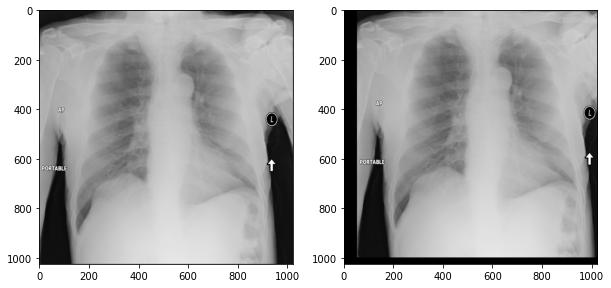

In [87]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(tf(image))

## Debug Augmentator

In [5]:
%run ../tools/augmentation.py

In [4]:
dataset = CXR14Dataset()
dataset.label_index.head()

,FileName,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000004_000.png,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [6]:
aug_dataset = Augmentator(dataset, dont_shuffle=True)
len(aug_dataset)

	Augmenting all samples:  times=1 new-total=529998 original=75714


529998

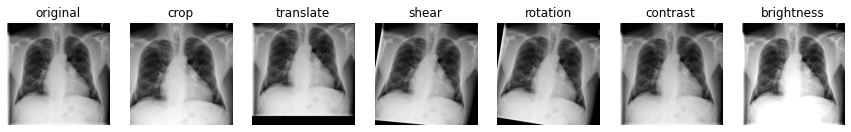

In [10]:
plot_augmented_samples(aug_dataset, 0)

In [18]:
sample_idx = 0
n_methods = len(aug_dataset._aug_fns)

start_idx = sample_idx * (n_methods + 1)
for i, method in enumerate(['original'] + list(aug_dataset._aug_fns)):
    idx = start_idx + i
    image = aug_dataset[idx].image
    print(f'{method:10}\t', image.type(), image.size(), image.min(), image.max())

original  	 torch.FloatTensor torch.Size([3, 512, 512]) tensor(-2.1802) tensor(2.1302)
crop      	 torch.FloatTensor torch.Size([3, 512, 512]) tensor(-2.1802) tensor(1.9780)
translate 	 torch.FloatTensor torch.Size([3, 512, 512]) tensor(-2.1802) tensor(1.9780)
shear     	 torch.FloatTensor torch.Size([3, 512, 512]) tensor(-2.1802) tensor(2.0118)
rotation  	 torch.FloatTensor torch.Size([3, 512, 512]) tensor(-2.1802) tensor(2.1133)
contrast  	 torch.FloatTensor torch.Size([3, 512, 512]) tensor(-1.3181) tensor(1.2512)
brightness	 torch.FloatTensor torch.Size([3, 512, 512]) tensor(-2.1802) tensor(2.1302)


## Debug Undersampler

In [9]:
from torch.utils.data import DataLoader

In [6]:
%run cxr14.py

In [56]:
dataset = CXR14Dataset('train', labels=['Atelectasis'], max_samples=10)
len(dataset)

10

In [59]:
dataset.get_labels_presence_for(0)

[(0, 1),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0)]

In [61]:
%run augmentation.py

In [62]:
dataset_aug = Augmentator(dataset)
len(dataset_aug)

	Augmenting all samples


60

In [63]:
dataset_aug.get_labels_presence_for(0)

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 1),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 1),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 1),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 1),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 0),
 (46, 1),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 1),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0)]

In [64]:
%run undersampler.py

In [66]:
sampler = OneLabelUnderSampler(dataset_aug, label=0)
dataloader = DataLoader(dataset_aug, batch_size=2, sampler=sampler)
sampler.resampled_indexes

	Undersampling Atelectasis (negative): positives=6 negatives=54 new-total=12 original=60


[43, 25, 30, 5, 17, 46, 36, 27, 9, 56, 54, 8]

In [20]:
for batch in dataloader:
    print(batch[1])

tensor([[0],
        [1]])


## Debug bounding-boxes

In [3]:
import json

In [4]:
bbox_fpath = os.path.join(DATASET_DIR, 'BBox_List_2017.csv')

In [5]:
df = pd.read_csv(bbox_fpath)
df.drop(columns=[c for c in df.columns if 'Unnamed' in c], inplace=True)
df.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [6]:
MAPPING = {
    'Infiltrate': 'Infiltration',
}

In [10]:
bbs_by_image = {}
ds = set()

for index, row in df.iterrows():
    image_name, disease, x, y, w, h = row

    if image_name not in bbs_by_image:
        bbs_by_image[image_name] = {}
    
    disease = MAPPING.get(disease, disease)
    ds.add(disease)
    
    bbs_by_image[image_name][disease] = [x, y, w, h]

In [8]:
filepath = os.path.join(DATASET_DIR, 'bbox_by_image_by_disease.json')
with open(filepath, 'w') as f:
    json.dump(bbs_by_image, f)